In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#!pip install petroeval
#pip install catboost
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, f1_score, roc_auc_score, classification_report
import lightgbm as lgb
#import keras
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout
#from keras.optimizers import Adam

In [2]:
import petroeval as pet

In [23]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata

def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata

def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, 0, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, 0, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, 0, traindata[_])
        
    return traindata


def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data

def show_evaluation(pred, true):
    print(f'Default score: {score(true.values, pred)}')
    print(f'Accuracy is: {accuracy_score(true, pred)}')
    print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
     
          
def plot_feat_imp(model):
  feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
  plt.figure(figsize=(12,8))
  #plt.xlabel([x for x in testdata.columns])
  feat_imp.plot(kind='bar', title='Feature Importances')
  plt.ylabel('Feature Importance Score')
        
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a

In [3]:
A = np.load('./penalty_matrix.npy')

def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def evaluate(model, prediction, true_label):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [4]:
#importing files
train = pd.read_csv('./Train.csv', sep=';')
test = pd.read_csv('./Test.csv', sep=';')

ntrain = train.shape[0]
ntest = test.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test)).reset_index(drop=True)

In [5]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology = lithology.map(lithology_numbers)

In [6]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 
        'DTS', 'DCAL', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO']
df = drop_columns(df, *cols)
print(df.shape)

(1307297, 29)
(1307297, 21)


In [7]:
df['log_GR'] = np.log(df.GR)
df['log_NPHI'] = np.log(df.NPHI)
df['log_RHOB'] = np.log(df.RHOB)
df['log_RSHA'] = np.log(df.RSHA)
df['log_RMED'] = np.log(df.RMED)
df['log_RDEP'] = np.log(df.RDEP)
df['space'] = (df.X_LOC * df.Y_LOC)/df.Z_LOC
df['depth_y'] = df.Y_LOC - df.DEPTH_MD
df['density'] = df.RHOB - df.DRHO

/home/olawale/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/olawale/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df = freq_encode(df, ['FORMATION', 'WELL', 'GROUP'])
print(df.shape)
df = mean_target(df, ['FORMATION', 'WELL', 'GROUP'])
df.shape

(1307297, 33)


(1307297, 36)

In [9]:
one_hot_cols = ['GROUP']

df = one_hot_encoding(df, *one_hot_cols)
print(df.shape)

(1307297, 49)


In [10]:
df = process(df)

In [11]:
df = df.drop(['FORMATION', 'WELL'], axis=1)
df.shape

df = df.fillna(-999)
data = df.copy()

train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

test2 = data[ntrain:].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)

In [11]:
train2

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
0,494.5280,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0,0,1,0,0,0,0,0,0,0
1,494.6800,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0,0,1,0,0,0,0,0,0,0
2,494.8320,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0,0,1,0,0,0,0,0,0,0
3,494.9840,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0,0,1,0,0,0,0,0,0,0
4,495.1360,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,3169.3124,-999.00000,-999.0,-999.000000,8.423170,-999.0,-999.000000,-999.000000,2.527984,77.654900,...,0,0,0,0,0,0,0,1,0,0
1170507,3169.4644,-999.00000,-999.0,-999.000000,8.379244,-999.0,-999.000000,-999.000000,2.537613,75.363937,...,0,0,0,0,0,0,0,1,0,0
1170508,3169.6164,-999.00000,-999.0,-999.000000,8.350248,-999.0,-999.000000,-999.000000,2.491860,66.452843,...,0,0,0,0,0,0,0,1,0,0
1170509,3169.7684,-999.00000,-999.0,-999.000000,8.313779,-999.0,-999.000000,-999.000000,2.447539,55.784817,...,0,0,0,0,0,0,0,1,0,0


In [12]:
traindata = train2
testdata = test2


#using StandardScaler function to scale the numeric features 

scaler = preprocessing.StandardScaler().fit(traindata)
traindata = scaler.transform(traindata)
testdata = scaler.transform(testdata)
traindata = pd.DataFrame(traindata, columns=train2.columns)
testdata = pd.DataFrame(testdata, columns=train2.columns)
traindata.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
0,-1.694334,-0.752515,-0.228628,1.705311,0.308476,-1.069363,0.159934,0.004074,0.398579,0.271305,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
1,-1.694182,-0.752515,-0.228628,1.705155,0.308430,-1.069363,0.159969,0.004054,0.398595,0.243904,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
2,-1.694029,-0.752515,-0.228628,1.704998,0.308430,-1.069363,0.160014,0.004088,0.398614,0.114173,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
3,-1.693877,-0.752515,-0.228628,1.704842,0.308395,-1.069363,0.159988,0.004093,0.398601,0.057410,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
4,-1.693724,-0.752515,-0.228628,1.704686,0.308372,-1.069363,0.159887,0.004051,0.398567,0.023821,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279


In [13]:
traindata = traindata.drop(['GROUP_TYNE GP.', 'GROUP_BOKNFJORD GP.', 'GROUP_HEGRE GP.'], axis=1)
testdata = testdata.drop(['GROUP_TYNE GP.', 'GROUP_BOKNFJORD GP.', 'GROUP_HEGRE GP.'], axis=1)

In [14]:
for i,j in (enumerate(testdata.columns)):
    print(i, j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DRHO
17 log_GR
18 log_NPHI
19 log_RHOB
20 log_RSHA
21 log_RMED
22 log_RDEP
23 space
24 depth_y
25 density
26 FORMATION_enc
27 WELL_enc
28 GROUP_enc
29 FORMATION_mean_target
30 WELL_mean_target
31 GROUP_mean_target
32 GROUP_BAAT GP.
33 GROUP_CROMER KNOLL GP.
34 GROUP_DUNLIN GP.
35 GROUP_HORDALAND GP.
36 GROUP_NORDLAND GP.
37 GROUP_ROGALAND GP.
38 GROUP_ROTLIEGENDES GP.
39 GROUP_SHETLAND GP.
40 GROUP_VESTLAND GP.
41 GROUP_VIKING GP.
42 GROUP_ZECHSTEIN GP.


In [22]:
#testdata = pd.DataFrame(scaler.transform(testdata))
testdata.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,28,29,30,31,32,34,35,36
0,-1.708273,-1.001526,-0.242627,1.719580,0.307434,-1.069363,0.159947,0.002170,0.399410,0.034024,...,-0.21631,-0.336542,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.151066,-0.356516,-0.10279
1,-1.708121,-1.001526,-0.242627,1.719423,0.307434,-1.069363,0.159737,0.001944,0.399412,0.036049,...,-0.21631,-0.336542,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.151066,-0.356516,-0.10279
2,-1.707969,-1.001526,-0.242627,1.719267,0.307434,-1.069363,0.159004,0.001874,0.399382,0.121541,...,-0.21631,-0.336542,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.151066,-0.356516,-0.10279
3,-1.707816,-1.001526,-0.242627,1.719111,0.307434,-1.069363,0.158150,0.001872,0.399355,0.286915,...,-0.21631,-0.336542,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.151066,-0.356516,-0.10279
4,-1.707664,-1.001525,-0.242627,1.718955,0.307434,-1.069363,0.157771,0.001853,0.399329,0.314077,...,-0.21631,-0.336542,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.151066,-0.356516,-0.10279


In [15]:
x_train, x_test, y_train, y_test = ms.train_test_split(traindata, lithology, test_size=0.25, random_state=42, stratify=lithology)
x_test1, x_test2, y_test1, y_test2 = ms.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [16]:
traindata.shape, testdata.shape, x_train.shape, x_test.shape, x_test1.shape, x_test2.shape

((1170511, 43),
 (136786, 43),
 (877883, 43),
 (292628, 43),
 (146314, 43),
 (146314, 43))

In [15]:
traindata.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,...,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,3.797611e-16,-5.216850e-13,-7.600893e-14,-9.499876e-15,-2.765990e-14,1.695025e-13,2.871772e-14,3.456052e-15,1.653729e-14,5.549697e-16,...,1.191698e-14,-9.024278e-13,1.033391e-12,-4.570949e-13,7.707317e-13,-2.626953e-13,-3.433544e-13,1.272045e-12,-2.279337e-12,-1.198743e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.053789e+00,-8.339007e+00,-1.017335e+01,-3.359680e+00,-3.509639e+00,-1.069363e+00,-5.162025e+00,-6.687969e+00,-2.501624e+00,-2.068401e+00,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
25%,-7.676537e-01,-4.614751e-01,-4.442049e-02,-6.955939e-01,2.687129e-01,-1.069363e+00,1.559967e-01,-1.959346e-03,3.989156e-01,-6.802652e-01,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
50%,-1.077857e-01,-7.367394e-02,1.726648e-01,1.002723e-01,2.820429e-01,8.954781e-01,1.588131e-01,1.596436e-03,3.996207e-01,-7.437794e-02,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
75%,6.822283e-01,6.741769e-01,2.537118e-01,7.759782e-01,2.944868e-01,8.973639e-01,1.651232e-01,9.016794e-03,4.002558e-01,5.293906e-01,...,-1.096779e-01,1.729973e+00,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
max,3.261738e+00,1.582211e+00,3.640139e-01,2.073835e+00,3.414585e-01,5.207002e+00,1.072823e+01,1.336470e+01,4.031385e-01,2.938963e+01,...,9.117606e+00,1.729973e+00,3.082012e+00,2.805579e+00,2.045085e+01,2.000396e+00,3.115090e+01,6.619644e+00,2.804920e+00,9.728598e+00


In [16]:
test.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
count,136786.000000,136727.000000,1.367270e+05,136727.000000,131141.000000,39097.000000,136199.000000,136727.000000,119826.000000,136786.000000,...,66627.000000,66964.000000,68316.000000,43220.000000,13515.000000,111556.000000,20269.000000,11316.000000,55790.000000,29848.000000
mean,2501.136889,467884.598172,6.708199e+06,-2397.835918,12.613567,3.137817,3.844914,3.662074,2.324925,65.223264,...,43.528467,10.963364,26.406939,185.389543,0.160979,0.014441,6.028683,4.906861,22.669058,5.280645
std,1043.245788,35865.313917,1.352924e+05,937.001116,3.218969,17.293036,24.170949,23.242750,0.243602,31.146538,...,25.530487,1.839420,31.913763,63.173605,0.536332,0.054151,49.607255,22.963156,13.436052,55.475790
min,227.296008,423237.531250,6.461833e+06,-4362.296387,6.682522,0.255146,0.148474,0.152317,1.289989,6.342400,...,-24.132233,8.500000,0.004297,79.327354,-6.402187,-1.213720,0.129413,0.063258,0.572329,0.262056
25%,1707.948917,442441.406250,6.605454e+06,-3171.749634,9.049458,0.850029,0.933067,0.902655,2.116576,44.557275,...,31.179566,8.500000,12.240131,146.022373,0.027619,-0.001835,0.134206,0.543010,12.753529,1.081298
50%,2471.823595,455904.187500,6.759398e+06,-2442.877197,12.428942,1.416000,1.669926,1.657664,2.376285,60.110472,...,48.967999,12.250001,20.878899,175.515274,0.124714,0.009203,0.143792,1.435970,19.927827,1.587683
75%,3294.643006,485144.859375,6.822772e+06,-1681.509216,14.177558,2.578526,3.088695,2.894494,2.531131,82.757637,...,62.133951,12.250001,31.232986,204.037148,0.247048,0.026884,0.149783,4.425004,29.882400,3.274492
max,5007.417976,548460.437500,6.853315e+06,-205.295288,27.344881,1566.168457,1901.766602,1582.094482,3.073430,500.878357,...,125.522781,17.500000,621.078247,494.096802,7.362912,0.404614,426.921356,957.984436,131.990906,2000.000000


In [34]:
open_pred = model.predict_proba(testdata)
open_pred = pd.DataFrame(open_pred)
open_pred = np.array(open_pred.idxmax(axis=1))

make_submission(open_pred, filename='ETR-0.091278-0.08905')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


In [35]:
open_pred = model.predict_proba(testdata)
open_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


array([[0.06, 0.09, 0.84, ..., 0.  , 0.  , 0.  ],
       [0.06, 0.1 , 0.83, ..., 0.  , 0.  , 0.  ],
       [0.06, 0.06, 0.88, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.36, 0.38, 0.12, ..., 0.  , 0.  , 0.  ],
       [0.38, 0.39, 0.08, ..., 0.  , 0.  , 0.  ],
       [0.46, 0.31, 0.08, ..., 0.  , 0.  , 0.  ]])

In [38]:
open_pred[-5:]

array([[0.39, 0.36, 0.12, 0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.38, 0.38, 0.12, 0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.36, 0.38, 0.12, 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.38, 0.39, 0.08, 0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.46, 0.31, 0.08, 0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ]])

In [30]:
test_result = model.predict_proba(x_test1)
val_result = model.predict_proba(x_test2)

pred_test_avg = pd.DataFrame(test_result)
pred_val_avg = pd.DataFrame(val_result)
#open_test_avg = pd.DataFrame(open_test_pred)

test_result = np.array(pred_test_avg.idxmax(axis=1))
val_result = np.array(pred_val_avg.idxmax(axis=1))
#open_result = np.array(open_test_avg.idxmax(axis=1))

print('----------------TEST EVALUATION------------------')
show_evaluation(test_result, y_test1)

print('----------------HOLD OUT EVALUATION------------------')
show_evaluation(val_result, y_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.7s finished


----------------TEST EVALUATION------------------
Default score: -0.0912780048389081
Accuracy is: 0.9667632625722761
F1 is: 0.966996473584909
----------------HOLD OUT EVALUATION------------------
Default score: -0.08905162868898396
Accuracy is: 0.967535574176087
F1 is: 0.9677541987235552


In [25]:
for i, j in enumerate(testdata.columns):
  print (i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DRHO
17 log_GR
18 log_NPHI
19 log_RHOB
20 log_RSHA
21 log_RMED
22 log_RDEP
23 space
24 depth_y
25 density
26 FORMATION_enc
27 WELL_enc
28 GROUP_enc
29 FORMATION_mean_target
30 WELL_mean_target
31 GROUP_mean_target
32 GROUP_BAAT GP.
33 GROUP_CROMER KNOLL GP.
34 GROUP_DUNLIN GP.
35 GROUP_HORDALAND GP.
36 GROUP_NORDLAND GP.
37 GROUP_ROGALAND GP.
38 GROUP_ROTLIEGENDES GP.
39 GROUP_SHETLAND GP.
40 GROUP_VESTLAND GP.
41 GROUP_VIKING GP.
42 GROUP_ZECHSTEIN GP.


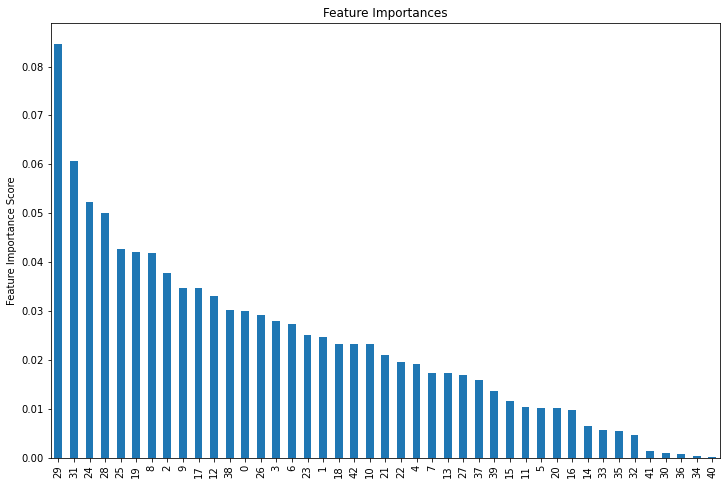

In [24]:
plot_feat_imp(model)

In [20]:
test_result = model.predict_proba(x_test1)
val_result = model.predict_proba(x_test2)

pred_test_avg = pd.DataFrame(test_result)
pred_val_avg = pd.DataFrame(val_result)
#open_test_avg = pd.DataFrame(open_test_pred)

test_result = np.array(pred_test_avg.idxmax(axis=1))
val_result = np.array(pred_val_avg.idxmax(axis=1))
#open_result = np.array(open_test_avg.idxmax(axis=1))

print('----------------TEST EVALUATION------------------')
show_evaluation(test_result, y_test1)

print('----------------HOLD OUT EVALUATION------------------')
show_evaluation(val_result, y_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.9s finished


----------------TEST EVALUATION------------------
Default score: -0.10855933130117419
Accuracy is: 0.9605711005098624
F1 is: 0.9610255777992498
----------------HOLD OUT EVALUATION------------------
Default score: -0.10816634088330576
Accuracy is: 0.9604685812704185
F1 is: 0.9608732015529735


In [29]:
model = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=2)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.8min finished


ExtraTreesClassifier(class_weight='balanced', random_state=42, verbose=2)

In [26]:
test_result = model.predict_proba(x_test1)
val_result = model.predict_proba(x_test2)

pred_test_avg = pd.DataFrame(test_result)
pred_val_avg = pd.DataFrame(val_result)
#open_test_avg = pd.DataFrame(open_test_pred)

test_result = np.array(pred_test_avg.idxmax(axis=1))
val_result = np.array(pred_val_avg.idxmax(axis=1))
#open_result = np.array(open_test_avg.idxmax(axis=1))

print('----------------TEST EVALUATION------------------')
show_evaluation(test_result, y_test1)

print('----------------HOLD OUT EVALUATION------------------')
show_evaluation(val_result, y_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.6s finished


----------------TEST EVALUATION------------------
Default score: -0.10588870511365966
Accuracy is: 0.9615074428967836
F1 is: 0.9619601154725789
----------------HOLD OUT EVALUATION------------------
Default score: -0.10415100400508495
Accuracy is: 0.9620132044780404
F1 is: 0.9624065995507596


In [16]:
test_result = model.predict_proba(x_test1)
val_result = model.predict_proba(x_test2)

pred_test_avg = pd.DataFrame(test_result)
pred_val_avg = pd.DataFrame(val_result)
#open_test_avg = pd.DataFrame(open_test_pred)

test_result = np.array(pred_test_avg.idxmax(axis=1))
val_result = np.array(pred_val_avg.idxmax(axis=1))
#open_result = np.array(open_test_avg.idxmax(axis=1))

print('----------------TEST EVALUATION------------------')
show_evaluation(test_result, y_test1)

print('----------------HOLD OUT EVALUATION------------------')
show_evaluation(val_result, y_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.1s finished


----------------TEST EVALUATION------------------
Default score: -0.10585965799581722
Accuracy is: 0.9615757890564129
F1 is: 0.96202220295844
----------------HOLD OUT EVALUATION------------------
Default score: -0.10501301994340938
Accuracy is: 0.9616783082958569
F1 is: 0.9620867617716202


Text(0, 0.5, 'Feature Importance Score')

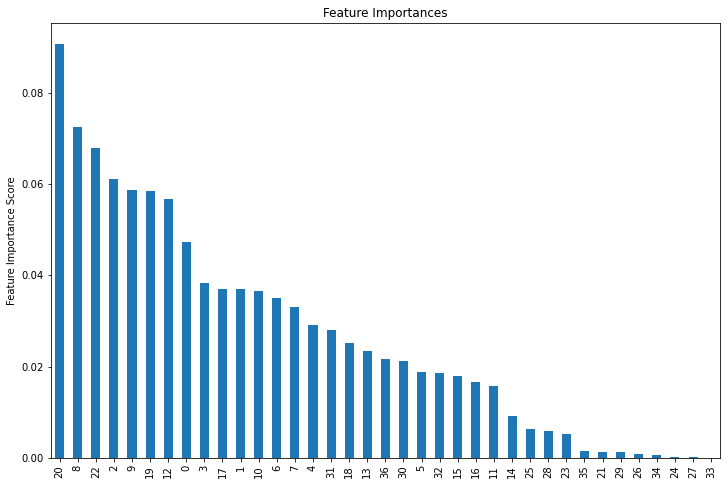

In [17]:
feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
 def make_submission(train, test)       
        
        test_result = np.array(pred_test_avg.idxmax(axis=1))
        val_result = np.array(pred_val_avg.idxmax(axis=1))
        open_result = np.array(open_test_avg.idxmax(axis=1))


        

        print('----------------TEST EVALUATION------------------')
        show_evaluation(test_result, self.y_test1)

        print('----------------HOLD OUT EVALUATION------------------')
        show_evaluation(val_result, self.y_test2)
                  
        if plot: self.plot_feat_imp(lgbm)
        return open_result, lgbm
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [33]:
def make_submission(prediction, filename):

  path = './'

  test = pd.read_csv('./Test.csv', sep=';')
  #test_prediction = model.predict(testdata)

  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
  

In [ ]:
make_submission(open_pred, filename='CATBOOST1-(UNKNOWN)xxx')

In [ ]:
n1 = df1.idxmax(axis=1)

In [ ]:
n1

0         2
1         2
2         2
3         2
4         2
         ..
136781    1
136782    1
136783    1
136784    1
136785    1
Length: 136786, dtype: int64

In [ ]:
np.array(n1)

array([2, 2, 2, ..., 1, 1, 1])